# We're trying to predict the ordinal variable damage_grade, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

1. represents low damage
2. represents a medium amount of damage
3. represents almost complete destruction

In [174]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [175]:
X_train = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/X_train.csv')
y_train = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/y_train.csv')
X_test = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/X_test.csv')
y_test = pd.read_csv('/Users/apple/5243AppliedDS/Modeling-Earthquake-Damage-main/Resources/Datasets/y_test.csv')
y_train = y_train['damage_grade']
y_test = y_test['damage_grade']
y_test

0        3
1        2
2        2
3        2
4        3
        ..
52116    2
52117    2
52118    2
52119    2
52120    1
Name: damage_grade, Length: 52121, dtype: int64

In [176]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [177]:
pca = PCA(n_components=0.50)  # Adjust n_components
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
# len(X_train_pca[0])
X_train_pca = X_train_scaled
X_test_pca = X_test_scaled
# check what is the best number of components
# pca = PCA()
# pca.fit(X_train_scaled)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1
# d

In [178]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

In [179]:
y_pred = decision_tree_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.48      0.47      5025
           2       0.70      0.70      0.70     29652
           3       0.60      0.61      0.61     17444

    accuracy                           0.65     52121
   macro avg       0.59      0.59      0.59     52121
weighted avg       0.65      0.65      0.65     52121



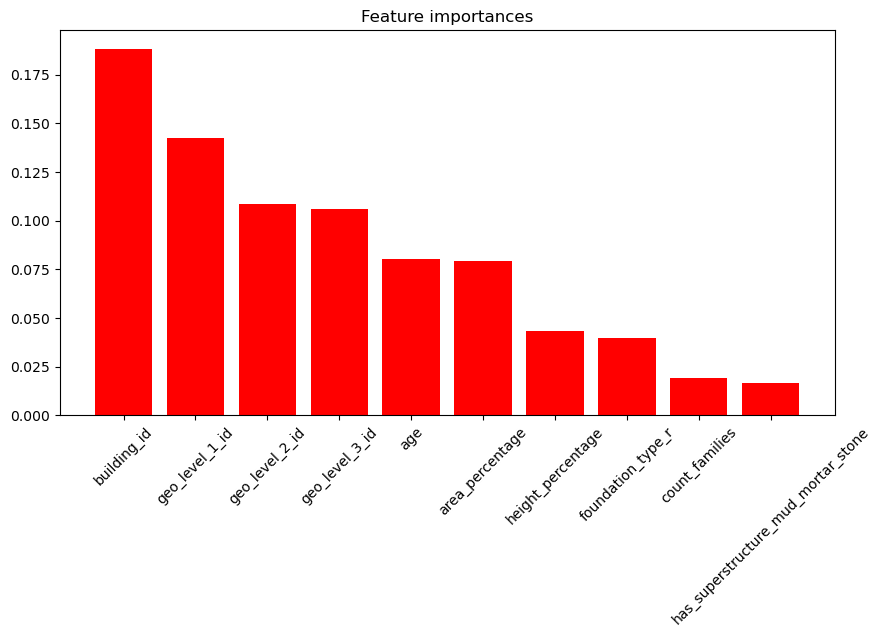

In [180]:
# find the top 10 important features
importances = decision_tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], color="r", align="center")
plt.xticks(range(10), features[indices[:10]], rotation=45)
plt.show()

/var/folders/50/6g30f9493n9b0mlh03m6xhbh0000gn/T/ipykernel_46971/3006466265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_features['damage_grade'] = y_train


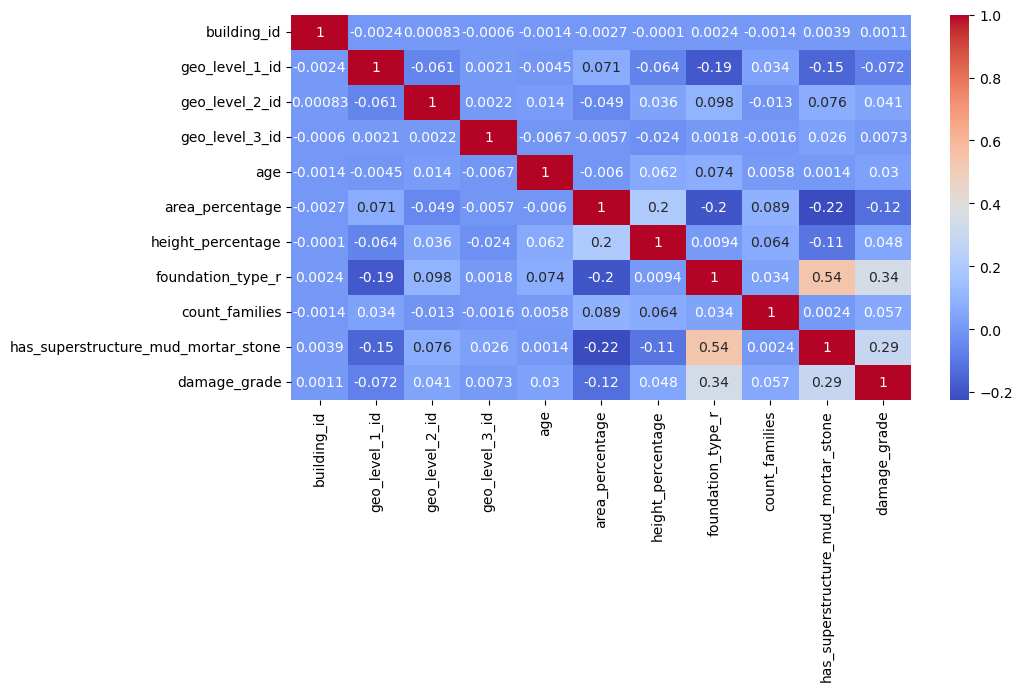

In [181]:
# finding the relationship of the top 5 important features and demage level
top_10_features = features[indices[:10]]
top_10_features = X_train[top_10_features]
top_10_features['damage_grade'] = y_train
plt.figure(figsize=(10, 5))
sns.heatmap(top_10_features.corr(), annot=True, cmap='coolwarm')
plt.show()


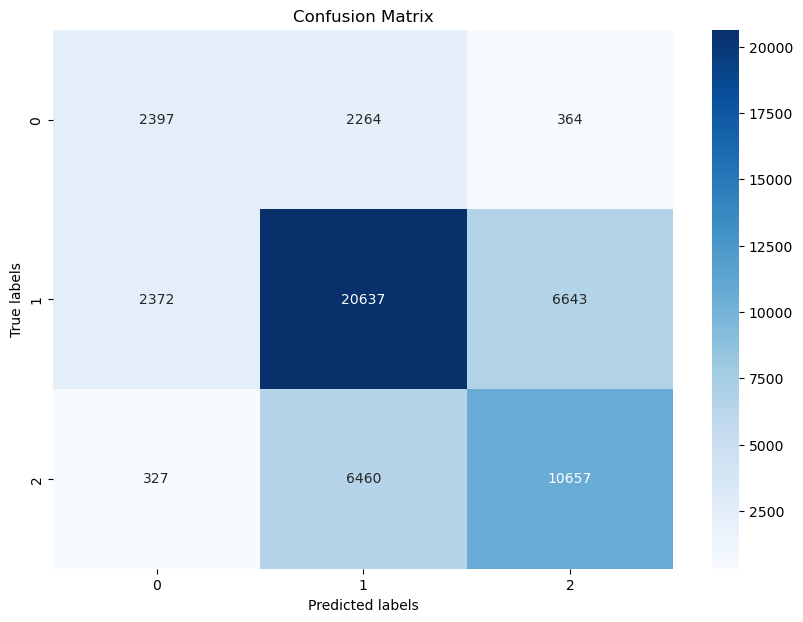

In [182]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [183]:
y_test_auc = pd.get_dummies(y_test)
y_pred_auc = pd.get_dummies(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_auc.iloc[:, i], y_pred_auc.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc

{0: 0.7098532245347072, 1: 0.6538525047117842, 2: 0.704430811936887}

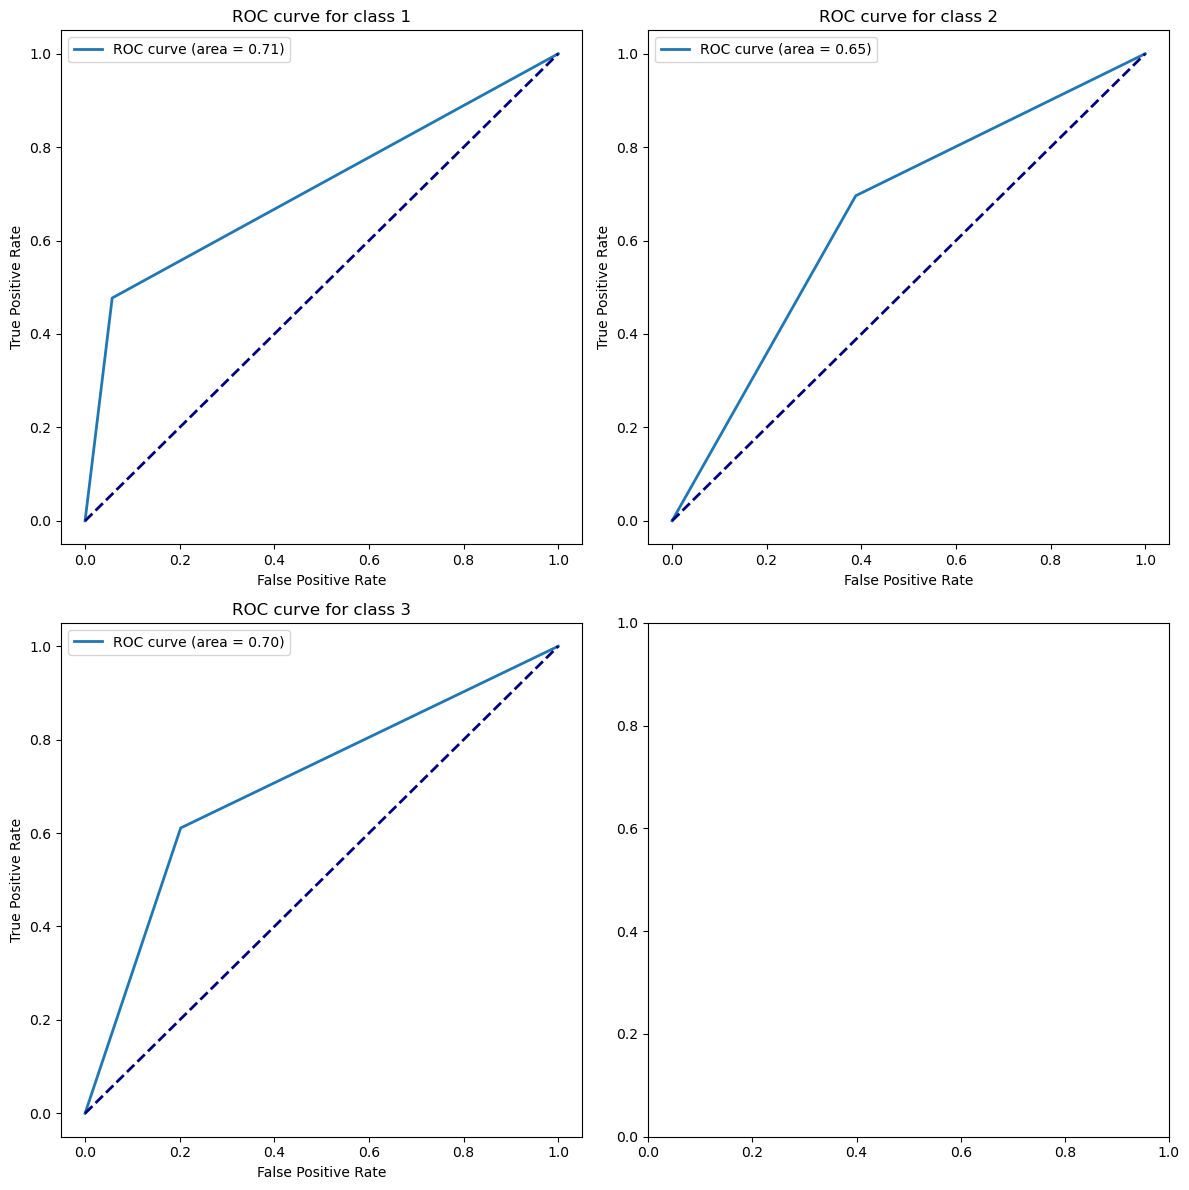

In [184]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Creates a 2x2 grid of Axes objects
axs = axs.ravel()  # Ravel turns a matrix into a vector, which is easier to iterate
for i in range(3):
    axs[i].plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[i].set_title('ROC curve for class {}'.format(i+1))
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()


In [185]:
# create a balanced dataset
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
class_counts = train['damage_grade'].value_counts()
test_class_counts = test['damage_grade'].value_counts()
min_class_count = class_counts.min()
min_class_test_count = test_class_counts.min()
# Use DataFrame.groupby and sample to resample each class
balanced_train = train.groupby('damage_grade').apply(lambda x: x.sample(min_class_count))
balanced_test = test.groupby('damage_grade').apply(lambda x: x.sample(min_class_test_count))
balanced_train = balanced_train.reset_index(drop=True)
balanced_test = balanced_test.reset_index(drop=True)

# shuffle the dataset
balanced_train = balanced_train.sample(frac=1)
balanced_test = balanced_test.sample(frac=1)

# drop the last column for X_train and the last colomn for y_train
balanced_X_train = balanced_train.drop('damage_grade', axis=1)
balenced_X_test = balanced_test.drop('damage_grade', axis=1)
balanced_y_train = balanced_train['damage_grade']
balanced_y_test = balanced_test['damage_grade']
balenced_X_test



,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
11949,734130,10,803,8508,2,20,10,5,0,1,...,False,False,False,False,False,False,False,False,True,False
6445,840756,13,1376,9556,2,30,6,5,0,1,...,False,False,False,False,False,False,False,False,True,False
14232,976785,17,1094,8623,2,35,5,5,0,1,...,False,False,False,False,False,False,False,False,True,False
9787,509536,4,747,3535,2,10,8,5,0,1,...,False,False,False,False,False,False,False,False,True,False
10789,977289,27,548,4430,5,120,13,10,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10879,917091,7,255,11900,3,35,12,6,0,1,...,False,False,False,False,False,False,False,False,True,False
436,991605,25,843,9937,2,40,7,4,0,1,...,False,False,False,False,False,False,False,False,True,False
8926,358232,6,96,1887,2,95,6,6,0,1,...,False,False,False,False,False,False,False,False,True,False
7945,117654,6,453,3656,3,5,9,6,0,1,...,False,False,False,False,False,False,False,False,True,False


In [186]:
scaler = StandardScaler()
balanced_X_train_scaled = scaler.fit_transform(balanced_X_train)
balenced_X_test_scaled = scaler.transform(balenced_X_test)

In [187]:
pca = PCA(n_components=0.95)  # Adjust n_components
# balanced_X_train_pca = pca.fit_transform(balanced_X_train_scaled)
# balenced_X_test_pca = pca.transform(balenced_X_test_scaled)
balanced_X_train_pca = balanced_X_train_scaled
balenced_X_test_pca = balenced_X_test_scaled
# len(balenced_X_test_pca[0])
# # check what is the best number of components
# pca = PCA()
# pca.fit(balanced_X_train_scaled)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.95) + 1
# d

In [188]:
balenced_decision_tree_clf = DecisionTreeClassifier(random_state=42)
balenced_decision_tree_clf.fit(balanced_X_train_pca, balanced_y_train)

DecisionTreeClassifier(random_state=42)

In [189]:
y_pred = balenced_decision_tree_clf.predict(balenced_X_test_pca)
print(classification_report(balanced_y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.73      0.73      5025
           2       0.50      0.50      0.50      5025
           3       0.65      0.66      0.65      5025

    accuracy                           0.63     15075
   macro avg       0.63      0.63      0.63     15075
weighted avg       0.63      0.63      0.63     15075



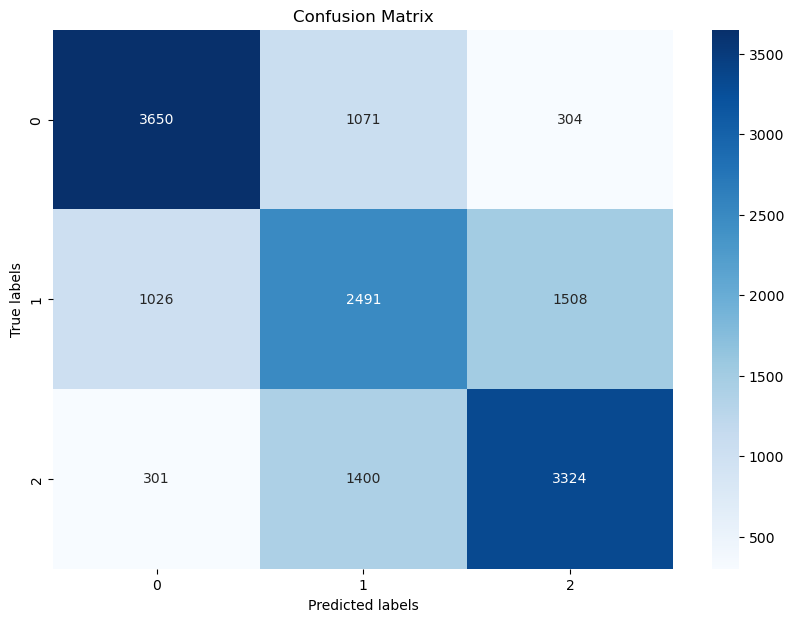

In [190]:
cm = confusion_matrix(balanced_y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [191]:
y_test_auc = pd.get_dummies(balanced_y_test)
y_pred_auc = pd.get_dummies(y_pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_auc.iloc[:, i], y_pred_auc.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc

{0: 0.7971641791044777, 1: 0.6249253731343284, 2: 0.7405970149253731}

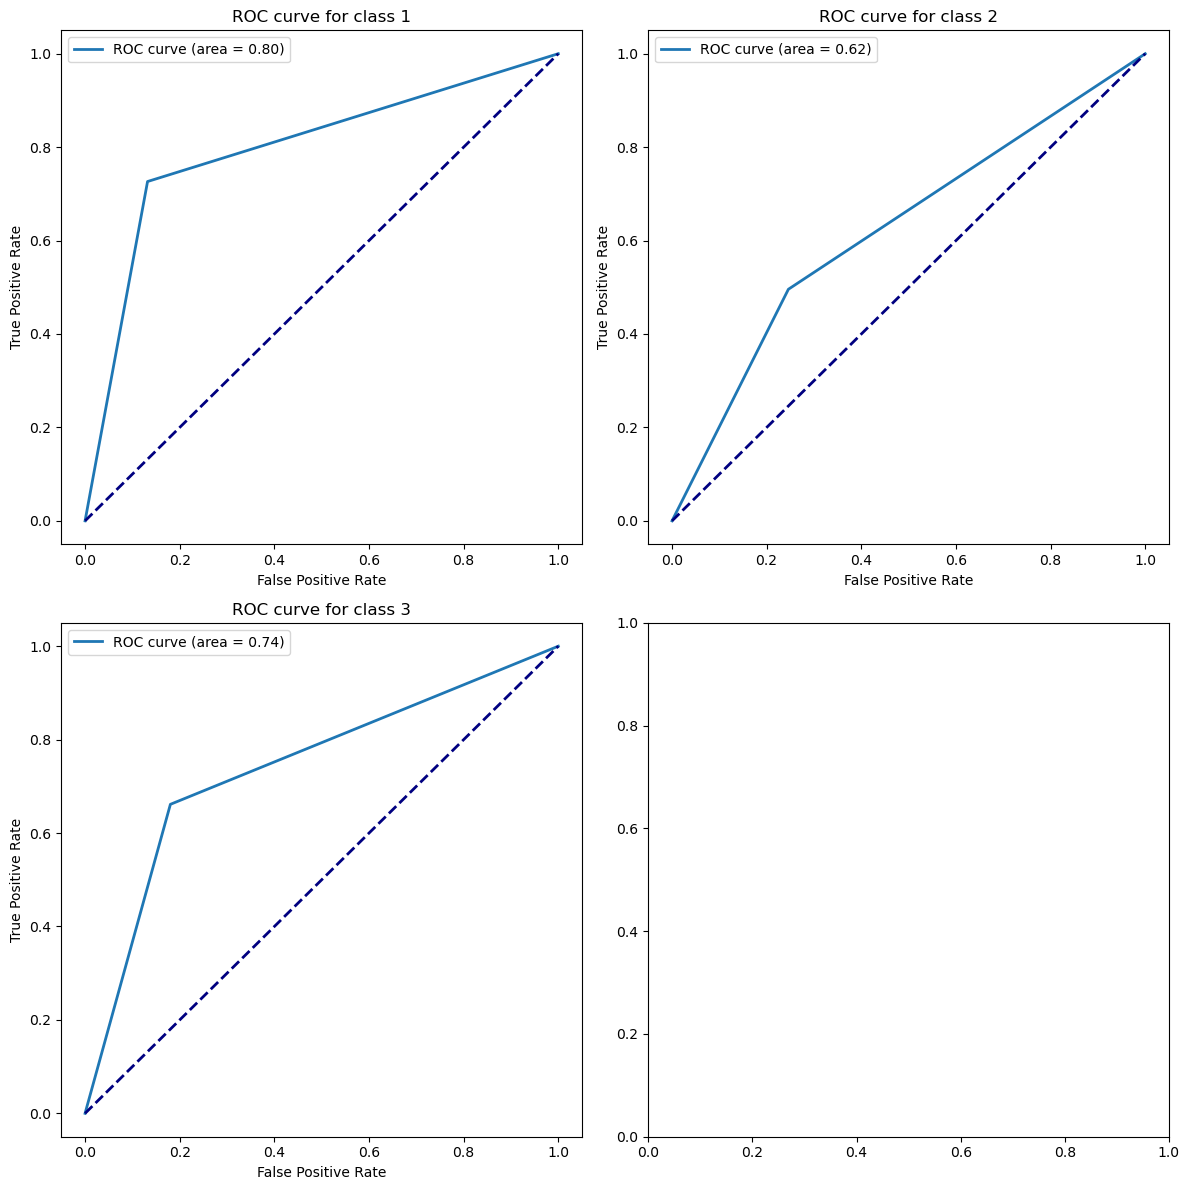

In [192]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Creates a 2x2 grid of Axes objects
axs = axs.ravel()  # Ravel turns a matrix into a vector, which is easier to iterate
for i in range(3):
    axs[i].plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axs[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[i].set_title('ROC curve for class {}'.format(i+1))
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()
